In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv
/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv


# Пояснение к курсовому проекту

После беглого осмотра данных попробуем углубиться в предметную область (с рынком недвижимости так или иначе сталкивался почти каждый).

Если смотреть различные анализы по рынку недвижимости, то на цену в первую очередь влияют метраж, район и класс жилья (бизнес, комфорт, эконом).

На втором плане инфраструктура, ремонт и возраст. 

Что мы имеем в данных:

* Метраж - дан в чистом виде.
* Район - есть, но дан номер района, который не говорит ни о чем. А мы его преобразуем в любимый параметр всех застройщиков и покупателей: **средняя цена за квадрат** =)
* Класс жилья - не дан даже близко, можно лишь попытаться выделить его по площади и году постройки, идею напишу ниже.
* Ремонт - тут никаких вариантов его добавить я не вижу и отсутвие этих данных, ИМХО, главная проблема на пути построения идеальной модельки.
* Инфрастурктура - присутсвуют в косвенном виде (Ecology, Social, Healthcare, Shops).
* Возраст - у нас есть год постройки будем использовать его

Первые пробы пера (простое обучение на голых данных с удалением пропусков) показали точность порядка 0.7, чтобы опуститься ниже 0.6 надо будет очень постараться =)

На мой взгляд такой неплохой показатель связан с тем, что есть глубочайшая корреляция метража и стоимости квартиры, именно этот параметр все решает и дает 70% точности при обучении.

Еще в фильтрах на сайтах недвижимости часто добавляют отдельный фильтр: *только не первый этаж* / *только не последний этаж*. Попробуем добавить и их.

Но, я свои основные надежды, конечно, возлагаю на новую фичу - средняя цена за квадрат по району. Надеюсь она позволит улучшить результат.


Мне очень понравился состав проекта, который был во втором вебинаре, буду его придерживаться.

# 1. Поставнока задачи

Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

# 2. Получение данных

Данные уже получены и выгружены в файлы.

#### Подключение нужных библиотек и данных

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

#### Читаем и смотрим на данные

In [3]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [5]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры


# 3. Анализ данных

In [10]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [11]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

По первому взгяду на данные, мы видим что:

#### DistrictId 
есть нулевые дистрикты (возможно пропуски), признак категориальный использовать для обучения не будем, вместо него надо сгенерировать новый.
#### Rooms 
есть нулевые значения (пропуски), есть выбросы.

Заменим выбросы и нулевые значения на расчет количества комнат по площади.

Рассчитывать будем так: если площадь меньше 30 - однущка, в остальных случаях из площади вычтем 15 метров (кухня + санузлы) и поделим на 15 (площадь одной комнаты).

т.е.: *ceil((square-15) / 15)*

#### Square 
Есть потенциальные выбросы в меньшую и большую стороны. Но вроде данные неплохие.

Т.к. площадь в вопросе цены вещь важная, не будeм ничем заменять данные с маленькими площадями, а просто выкинем Все что меньше 10м2.

А с большими площадями посмотрим на адекватность их цены.

#### LifeSquare
много пропусков и есть очевидные выбросы в большую и меньшую стороны.

Заменим все выбросы (<10, >300), пропуски и несоответствия (больше площади квартиры) на расчет по площади: из площади будем вычитать площадь кухни (или 12 если площадь кухни слишком большая) и еще 14 метров (почему 14? потому что если посмотреть на медианы: square - LifeSquare - KitchenSquare = 14).

т.е. *square - min(kitchensquare,12) - 14*

#### KitchenSquare
есть нулевые значения (пропуски), есть выбросы.

Заменим все подозрительные значения (<3, >40), пропуски и несоответствия (больше площади квартиры) на моду.

#### Floor
Данные отличные.

А при несоответсвиях будем менять HouseFloor, к ним доверия меньше. Свой этаж все знают, а с этажностью дома легко ошибиться.

#### HouseFloor 
есть нулевые значения (пропуски), есть выбросы.

Заменим все подозрительные значения (<1, >80), пропуски и несоответствия (ниже этажа квартиры) на этаж + 1.

#### HouseYear 
есть нулевые значения (пропуски), есть выбросы.

Рассмотрим отдельно.

#### Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1 
сложно сказать, можем только исключать их из обучения и смотреть как это повлияет.

#### Ecology_2, Ecology_3, Shops_2 
Категориальные признаки, надо будет преобразовать в числовые.
#### Price 
вроде неплохие данные.

# 4. Визуализация данных

Я, конечно, все посмотрел, но интерес представляют следующие:

In [12]:
# вывод распредления
def distributionPlot(df, param):
    plt.figure(figsize = (16, 8))

    df[param].hist(bins=30)
    plt.ylabel('Count')
    plt.xlabel(param)

    plt.title(param + ' distribution')
    plt.show()

### Price

Посмотрим на распредлеение целевой переменной.

Там вроде все более менее - ок.

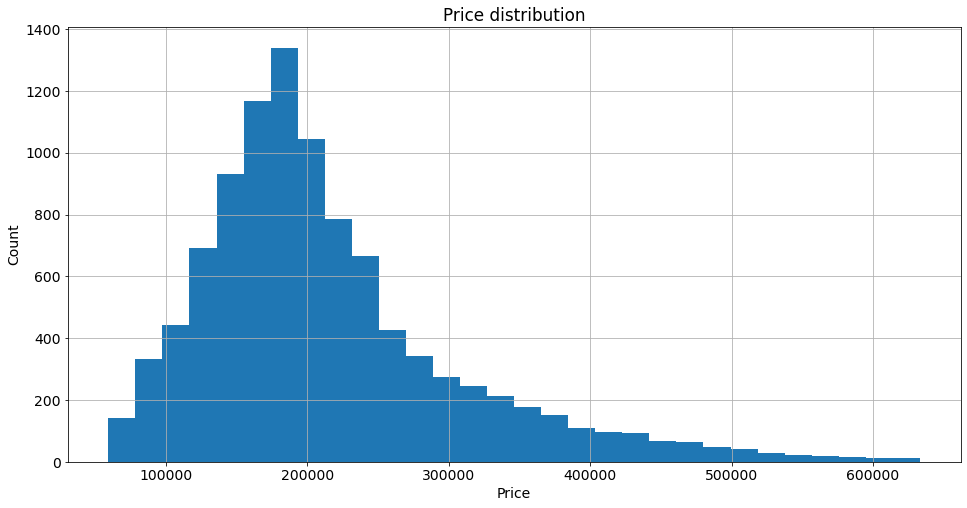

In [13]:
distributionPlot(train_df, 'Price')

### DistrictId

In [14]:
train_df.loc[train_df['DistrictId']==0]['DistrictId'].value_counts()

0    48
Name: DistrictId, dtype: int64

### Square

По площади данные неплохие, но есть кусок маленьких площадей.

Есть ярко выраженный хвост вправо.

Посмотрим цены на это хвостатые квартиры отдельно.

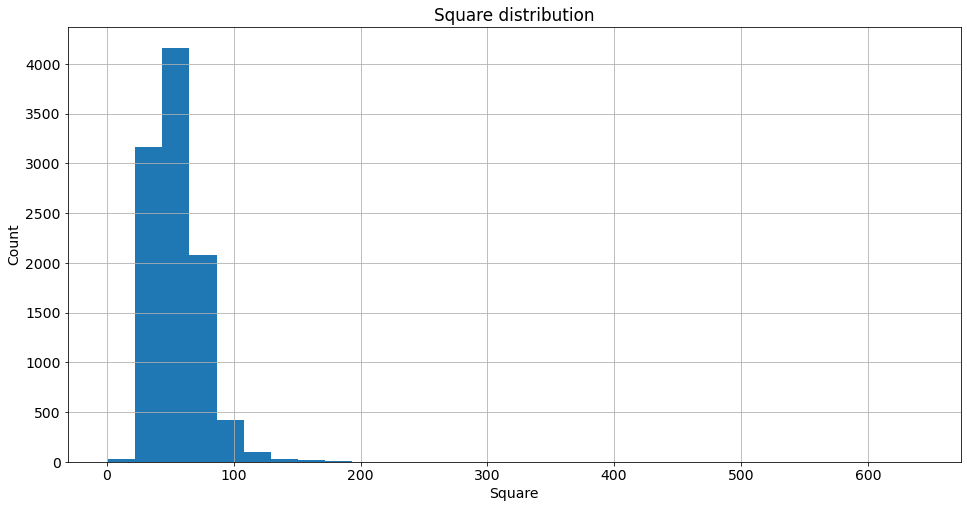

In [15]:
distributionPlot(train_df, 'Square')

In [16]:
train_df.loc[train_df['Square']>300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


Видно, что по цене и количеству комнат данные не соответствуют своей площади, тоже удалим их

#### Ecology_1

Рассмотрим его, чтобы убедиться что эти данные не имеют нормальное распределение и по ним ничего не ясно.

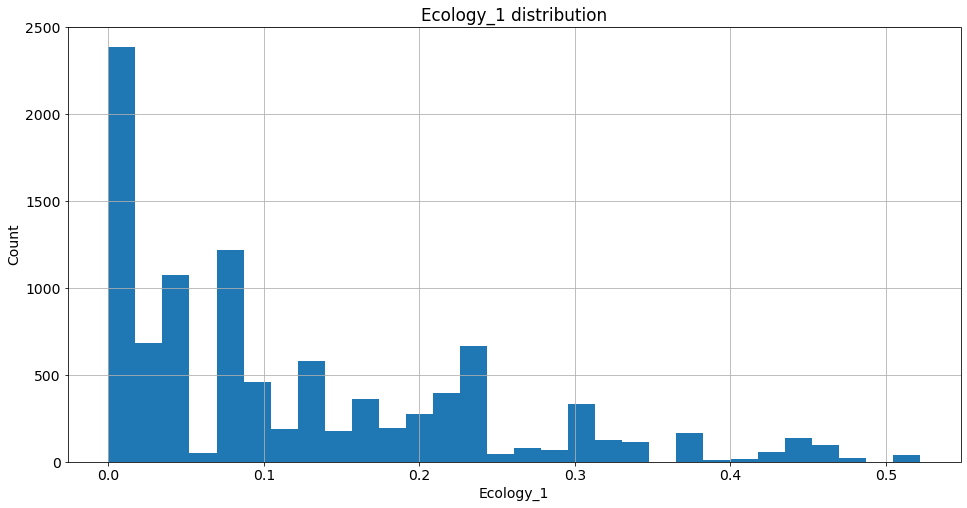

In [17]:
distributionPlot(train_df, 'Ecology_1')

#### HouseYear

Тут видно, что есть 2 выбивающихся значения, заменим их на моду

In [18]:
train_df.loc[train_df['HouseYear']>2020]['HouseYear'].value_counts()

20052011    1
4968        1
Name: HouseYear, dtype: int64

In [19]:
train_df.loc[train_df['HouseYear']<1900]['HouseYear'].value_counts()

Series([], Name: HouseYear, dtype: int64)

#### Ecology_2, Ecology_3, Shops_2

Ничего примечательного обычные бинарные признаки

In [20]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [21]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [22]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# 5. Предобработка данных

Действуем по описаному выше плану.

Для этого заведем вспомогательные функции.

In [23]:
# обрезаем данные по параметру 
def cropDf(df, param, fromVal, toVal):
    df = df.loc[df[param].notnull()]
    df = df.loc[df[param]>fromVal]
    df = df.loc[df[param]<toVal]
    return df

# Расчет площади комнаты
def fixRooms(df, minRooms, maxRooms):
    calcRooms(df, (df['Rooms']<minRooms))
    calcRooms(df, (df['Rooms']>maxRooms))
    calcRooms(df, (df['Rooms'].isna()))
    df.loc[df['Rooms']<1, 'Rooms'] = 1
    return df

def calcRooms(df, condition):
    df.loc[condition, 'Rooms'] = round((df.loc[condition, 'Square'] - 15) / 15)
    return df

# Заменяем данные по параметру 
def replaceWrongVal(df, param, minVal, maxVal, value):
    df.loc[df[param]<minVal, param] = value
    df.loc[df[param]>maxVal, param] = value
    df.loc[df[param].isna(), param] = value
    return df

# Расчет жилой площади по площади квартиры
def fixLifeSquare(df, minVal, maxVal):
    calcLifeSquare(df, (df['LifeSquare']<minVal))
    calcLifeSquare(df, (df['LifeSquare']>maxVal))
    calcLifeSquare(df, (df['LifeSquare']>df['Square']))
    calcLifeSquare(df, (df['LifeSquare'].isna()))
    df.loc[df['LifeSquare']<1, 'LifeSquare'] = 1
    return df

def calcLifeSquare(df, condition):
    df.loc[condition, 'LifeSquare'] = (df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare']) - 14
    return df

# Расчет Этажности дома
def fixHouseFloor(df, minVal, maxVal):
    calcHouseFloor(df, (df['HouseFloor']<minVal))
    calcHouseFloor(df, (df['HouseFloor']>maxVal))
    calcHouseFloor(df, (df['HouseFloor']<df['Floor']))
    calcHouseFloor(df, (df['HouseFloor'].isna()))
    df.loc[df['HouseFloor']<1, 'HouseFloor'] = 1
    return df

def calcHouseFloor(df, condition):
    df.loc[condition, 'HouseFloor'] = df.loc[condition, 'Floor'] + 1
    return df

source_df = train_df

In [24]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.modes=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.modes = X.mode()
    
    def transform(self, X):
        """Трансформация данных"""

        # заполним комнаты
        X = fixRooms(X, 2, 10)

        # заменяем года с ошибками на моду
        X = replaceWrongVal(X, 'HouseYear', 1900, datetime.now().year, self.modes['HouseYear'][0])

        # заменяем странные площади кухонь на моду
        X = replaceWrongVal(X, 'KitchenSquare', 3, 40, self.modes['KitchenSquare'][0])
        condition = X['KitchenSquare']>X['Square']
        X.loc[condition, 'KitchenSquare'] = self.modes['KitchenSquare'][0]

        # заполним жилую площадь
        X = fixLifeSquare(X, 10, 300)

        # заполним этажность
        X = fixHouseFloor(X, 1, 80)

        # заполним Healthcare_1
        condition = X['Healthcare_1'].isna()
        X.loc[condition, 'Healthcare_1'] = self.medians['Healthcare_1']
        
        return X

In [25]:
train_df = source_df

# удаляем выбросы Square
train_df = cropDf(train_df, 'Square', 10, 300)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [26]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

# 6. Генерация новых признаков

Тут мы уже определились с планом, нужно добавить:
* средняя цена за квадрат по району
* первести в бинарные признаки Ecology_2, Ecology_3, Shops_2
* квартира на первом этаже
* квартира на последнем этаже
* Возраст дома, а не год его постройки
* параметр для класса недвижимости


Класс недвижимости мы будем определять по дате строительства и площади на комнату: 
* если дата строительства > 2010 и площадь на комнату > 30 - бизнес (2)
* если дата строительства > 2010 и площадь на комнату > 20 - комфорт (1)
* все остальное - бюджет (0)

In [27]:
# конвертируем категорию в бинарный признак
def catToBin(df, param, binary_to_numbers):
    df[param] = df[param].map(binary_to_numbers)
    return df

In [28]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.sq_price_by_district = None
        self.sq_price_by_district_median = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
                       
        # Средняя цена за квадрат по району
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            df['SqPrice'] = df['Price'] / df['Square']
            
            self.sq_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'SqPrice':'median'})\
                                            .rename(columns={'SqPrice':'SqPriceByDistrict'})
            
            self.sq_price_by_district['DistrictId'].astype('int64')
            self.sq_price_by_district_median = df['SqPrice'].median()
        

        
    def transform(self, X):
        
        # Добавляем среднюю цену за квадрат в районе
        if self.sq_price_by_district is not None:
            X = X.merge(self.sq_price_by_district, on=['DistrictId'], how='left')
            X.fillna(self.sq_price_by_district_median, inplace=True)
        
        # Конвертируем категориальные признаки
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # Квартира на первом этаже
        X['isFirstFloor'] = 0
        X.loc[X['Floor']==1, 'isFirstFloor'] = 1
        
        # Квартира на последнем этаже
        X['isLastFloor'] = 0
        X.loc[X['Floor']==X['HouseFloor'], 'isLastFloor'] = 1
        
        # класс недвижимости
        X['sqPerRoom'] = X['LifeSquare'] / X['Rooms']
        X['Class'] = 0
        X.loc[X['sqPerRoom']>20, 'Class'] = 1
        X.loc[X['sqPerRoom']>30, 'Class'] = 2
        
        # Возраст недвижимости
        X['Age'] = datetime.now().year - X['HouseYear']
        
        return X

In [29]:
features_gen = FeatureGenetator()
features_gen.fit(train_df.drop(columns='Price'), train_df['Price'])

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

In [30]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,SqPriceByDistrict,isFirstFloor,isLastFloor,sqPerRoom,Class,Age
count,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,...,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000
mean,8383.644266,50.429745,2.191688,56.230160,37.786382,5.786380,8.522784,13.586580,1984.856284,0.118864,...,1.319579,4.230546,0.917376,214097.678076,3927.752188,0.023335,0.090436,17.372413,0.302554,35.143716
std,4859.124846,43.599915,0.703493,19.077255,17.400188,3.950406,5.232639,5.804986,18.409218,0.119063,...,1.493617,4.804400,0.275327,92774.269739,997.144114,0.150973,0.286819,5.747308,0.533811,18.409218
min,0.000000,0.000000,1.000000,13.784865,1.000000,1.000000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,2273.498737,0.000000,0.000000,0.333333,0.000000,0.000000
25%,4170.000000,20.000000,2.000000,41.784835,24.442781,1.000000,4.000000,9.000000,1974.000000,0.017647,...,0.000000,1.000000,1.000000,153912.044504,2938.048239,0.000000,0.000000,13.690663,0.000000,19.000000
50%,8394.000000,36.000000,2.000000,52.539365,33.543883,6.000000,7.000000,14.000000,1977.000000,0.075424,...,1.000000,3.000000,1.000000,192302.751941,4134.353749,0.000000,0.000000,16.173653,0.000000,43.000000
75%,12594.000000,75.000000,3.000000,65.904217,46.856174,9.000000,12.000000,17.000000,2001.000000,0.195781,...,2.000000,6.000000,1.000000,249114.537525,4562.026777,0.000000,0.000000,20.387521,1.000000,46.000000
max,16798.000000,209.000000,13.000000,275.645284,233.949309,40.000000,42.000000,48.000000,2020.000000,0.521867,...,6.000000,23.000000,1.000000,633233.466570,8700.768533,1.000000,1.000000,77.689747,2.000000,110.000000


# 5. Отбор признаков

In [31]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'Ecology_2', 'Ecology_3']

new_feature_names = ['SqPriceByDistrict', 'isFirstFloor', 'isLastFloor', 'Class', 'Age']

target_name = 'Price'

In [32]:
train_df.isna().sum()

Id                   0
DistrictId           0
Rooms                0
Square               0
LifeSquare           0
KitchenSquare        0
Floor                0
HouseFloor           0
HouseYear            0
Ecology_1            0
Ecology_2            0
Ecology_3            0
Social_1             0
Social_2             0
Social_3             0
Healthcare_1         0
Helthcare_2          0
Shops_1              0
Shops_2              0
Price                0
SqPriceByDistrict    0
isFirstFloor         0
isLastFloor          0
sqPerRoom            0
Class                0
Age                  0
dtype: int64

# 6. Разбиение на train и test

In [33]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

test_df = test_df[feature_names + new_feature_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# 7. Построение модели

In [34]:
%%time
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

gb_model = GradientBoostingRegressor(
                                     min_samples_leaf=7,
                                     random_state=42,  
                                     n_estimators=100,
                                     max_depth=6,
                                     criterion='mse')

gb_model.fit(X_train, y_train)

CPU times: user 2.74 s, sys: 0 ns, total: 2.74 s
Wall time: 2.74 s


GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=7,
                          random_state=42)

# 8. Оценка качества

Train R2:	0.885
Test R2:	0.76


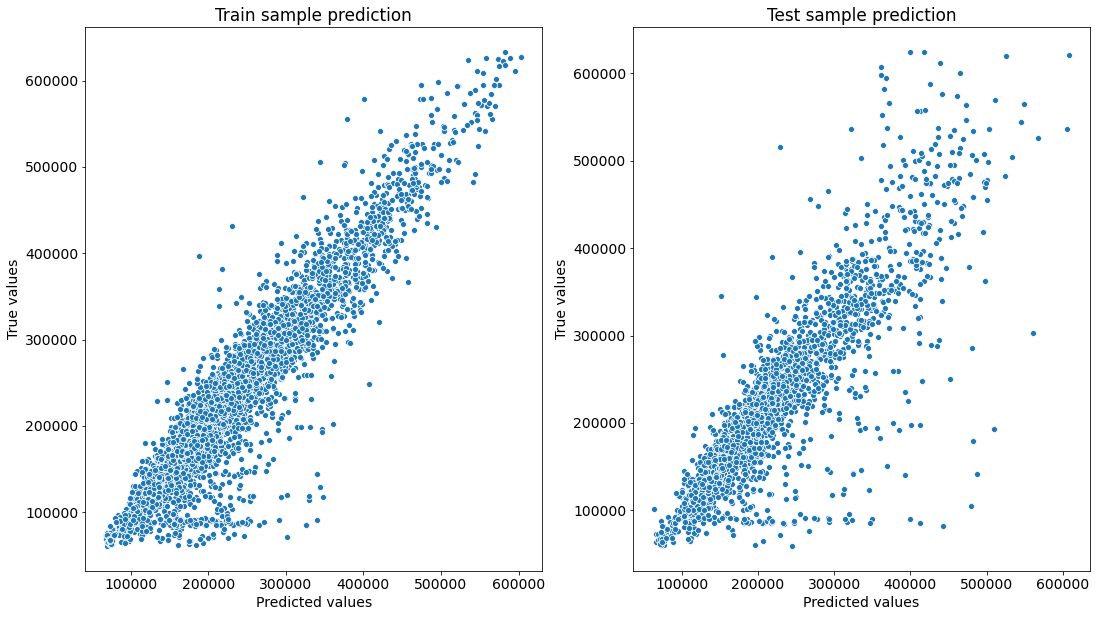

In [35]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Кросс-валидация

In [36]:
cv_score = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75571344, 0.76502286, 0.75154032])

In [37]:
cv_score.mean()

0.7574255395225752

In [38]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.468728
15,SqPriceByDistrict,0.387067
19,Age,0.022161
3,KitchenSquare,0.018054
2,LifeSquare,0.015768
6,Ecology_1,0.015244
5,HouseFloor,0.014327
7,Social_1,0.012708
4,Floor,0.011077
8,Social_2,0.010805


# 9. Внедрение модели

In [39]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [40]:
test_df.isna().sum()

Rooms                0
Square               0
LifeSquare           0
KitchenSquare        0
Floor                0
HouseFloor           0
Ecology_1            0
Social_1             0
Social_2             0
Social_3             0
Helthcare_2          0
Shops_1              0
Shops_2              0
Ecology_2            0
Ecology_3            0
SqPriceByDistrict    0
isFirstFloor         0
isLastFloor          0
Class                0
Age                  0
dtype: int64

In [41]:
predictions = gb_model.predict(test_df)

In [42]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,172895.033229
1,5925,117394.427479
2,960,137913.571163
3,3848,105684.167548
4,746,183658.895616


In [43]:
submit.to_csv('gb_submit.csv', index=False)